In [1]:
import matplotlib.pyplot as plt
import os
from model.Unet import UNetWithDropout
from model import UNet
import torch
from dataset.SphDataset import Dataset3d
import numpy as np
from tqdm import tqdm
from scipy.ndimage import zoom
from util.metric import get_metric
import pandas as pd

# 生成表格

In [2]:
@torch.no_grad()
def test(model, dataloader, batch_size, input_size):
    device = next(iter(model.parameters())).device
    model.eval()
    tbar = tqdm(dataloader)
    dice_his, iou_his, assd_his = [], [], []
    for idx, (img, mask) in enumerate(tbar):
        img, mask = img[0], mask[0]
        h, w = img.shape[-2], img.shape[-1]
        batch_pred = []
        for batch in range(0, img.shape[0], batch_size):
            last = batch + batch_size
            batch_slices = img[batch:] if last >= img.shape[0] else img[batch:last]

            batch_slices = zoom(batch_slices, (1, 1, input_size / h, input_size / w), order=0,
                                mode='nearest')
            batch_slices = torch.from_numpy(batch_slices).to(device)
            output = model(batch_slices)
            if isinstance(output, tuple):
                output = output[0]
            batch_pred_mask = output.argmax(dim=1).cpu()
            batch_pred_mask = zoom(batch_pred_mask, (1, h / input_size, w / input_size), order=0,
                                   mode='nearest')
            batch_pred.append(batch_pred_mask)

        pred_volume = np.concatenate(batch_pred)
        del batch_pred
        dice, iou, assd = get_metric(pred_volume, np.asarray(mask.squeeze(1)))

        tbar.set_description(
            f"EVAl | Dice:{dice:.3f} Mean IoU: {iou:.2f} asd: {assd:.2f} ")

        dice_his.append(dice)
        iou_his.append(iou)
        assd_his.append(assd)
    return np.array(dice_his), np.array(iou_his), np.array(assd_his)

In [5]:
dataset_test = Dataset3d(folder="data/preprocessed/test")

dataloader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=1,
                                         persistent_workers=True,
                                         pin_memory=True,
                                         prefetch_factor=4,
                                         num_workers=4)

In [4]:
folder = "/home/yeep/桌面/ck"
dt = {
    "Method": os.listdir(folder),
    "DSC": [],
    "Foreground IoU": [],
    "ASSD": []
}

In [ ]:
cycle = 10
for method in dt["Method"]:
    #选dice训练过程验证集上dice最大的权重测试
    print(method)
    maxdice_ckname = \
        sorted(os.listdir(f"{folder}/{method}/checkpoint"), key=lambda x: float({k.split("=")[0]:k.split("=")[1] for k in x.split("&")}["dice"]))[cycle]
    if method == "BALD":
        model = UNetWithDropout(1, 2, 16).to("cuda")
    else:
        model = UNet(1, 2, 16).to("cuda")
    model.load_state_dict(torch.load(f"{folder}/{method}/checkpoint/{maxdice_ckname}"))
    model.eval()
    dice_his, mean_iou_his, assd_hist = test(model, dataloader, 32, 416)
    dice_mean, dice_std = np.mean(dice_his), np.std(dice_his)
    meaniou, mean_std = np.mean(mean_iou_his), np.std(mean_iou_his)
    assd_mean, assd_std = np.mean(assd_hist), np.std(assd_hist)
    dt["DSC"].append(f"{dice_mean:.3f} ± {dice_std:.3f}")
    dt["Foreground IoU"].append(f"{meaniou:.3f} ± {mean_std:.3f}")
    dt["ASSD"].append(f"{assd_mean:.3f} ± {assd_std:.3f}")

In [ ]:
pd.DataFrame(dt).to_excel("0.83.xlsx", index=None)

# 画图

In [6]:
DSC = {method: [] for method in os.listdir(folder)}
IoU = {method: [] for method in os.listdir(folder)}
ASSD = {method: [] for method in os.listdir(folder)}

In [7]:
#本文数据集中有标签数据在主动循环过程中的变换情况
x = [0.2776, 0.3331, 0.3887, 0.4443, 0.4999, 0.5554, 0.611, 0.6666, 0.7221, 0.7777, 0.8333, 0.8889, 0.9444, 1.0]

In [8]:
for method in os.listdir(folder):
    if method == "BALD":
        model = UNetWithDropout(1, 2, 16).to("cuda")
    else:
        model = UNet(1, 2, 16).to("cuda")
    cknames_sortbycycle = \
        sorted(os.listdir(f"{folder}/{method}/checkpoint"), key=lambda x: float({k.split("=")[0]:k.split("=")[1] for k in x.split("&")}["dice"]))
    for ckname in cknames_sortbycycle:
        model.load_state_dict(torch.load(f"{folder}/{method}/checkpoint/{ckname}"))
        model.eval()
        dice_his, mean_iou_his, assd_hist = test(model, dataloader, 32, 416)
        dice_mean, meaniou, assd_mean = round(dice_his.mean(), 4), round(mean_iou_his.mean(), 4), round(
            assd_hist.mean(), 4)
        DSC[method].append(dice_mean)
        IoU[method].append(meaniou)
        ASSD[method].append(assd_mean)

EVAl | Dice:0.545 Mean IoU: 0.38 asd: 12.17 : 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]
EVAl | Dice:0.716 Mean IoU: 0.56 asd: 4.35 : 100%|██████████| 15/15 [00:18<00:00,  1.21s/it] 
EVAl | Dice:0.668 Mean IoU: 0.50 asd: 5.61 : 100%|██████████| 15/15 [00:18<00:00,  1.21s/it] 
EVAl | Dice:0.730 Mean IoU: 0.57 asd: 3.54 : 100%|██████████| 15/15 [00:17<00:00,  1.19s/it] 
EVAl | Dice:0.747 Mean IoU: 0.60 asd: 3.84 : 100%|██████████| 15/15 [00:17<00:00,  1.19s/it] 
EVAl | Dice:0.760 Mean IoU: 0.61 asd: 3.32 : 100%|██████████| 15/15 [00:17<00:00,  1.20s/it] 
EVAl | Dice:0.712 Mean IoU: 0.55 asd: 3.52 : 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
EVAl | Dice:0.786 Mean IoU: 0.65 asd: 2.62 : 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
EVAl | Dice:0.776 Mean IoU: 0.63 asd: 1.73 : 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
EVAl | Dice:0.793 Mean IoU: 0.66 asd: 2.44 : 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
EVAl | Dice:0.796 Mean IoU: 0.66 asd: 1.75 : 100%|██████████| 15

In [9]:
DSC

{'LeastConfidence': [0.317,
  0.4316,
  0.4654,
  0.4965,
  0.5213,
  0.5586,
  0.5902,
  0.619,
  0.6312,
  0.6611,
  0.6708,
  0.6804,
  0.7377,
  0.76],
 'RandomQuery': [0.3206,
  0.437,
  0.4987,
  0.5185,
  0.5399,
  0.5632,
  0.6021,
  0.6359,
  0.6474,
  0.6842,
  0.7214,
  0.7304,
  0.7232,
  0.7613],
 'BALD': [0.4104,
  0.4403,
  0.5636,
  0.6118,
  0.6553,
  0.6583,
  0.674,
  0.6907,
  0.7137,
  0.7185,
  0.7143,
  0.727,
  0.775,
  0.7922],
 'FullLabel': [0.2403,
  0.3599,
  0.3774,
  0.44,
  0.4637,
  0.4854,
  0.5234,
  0.5697,
  0.5667,
  0.5683,
  0.5895,
  0.5823,
  0.6183,
  0.6284,
  0.6138,
  0.6359,
  0.6605,
  0.6482,
  0.667,
  0.6714,
  0.6564,
  0.673,
  0.6955,
  0.6945,
  0.6994,
  0.6876,
  0.6894,
  0.7164,
  0.699,
  0.7251,
  0.7268,
  0.7184,
  0.7241,
  0.7383,
  0.7468,
  0.7486,
  0.7559,
  0.7511,
  0.7527,
  0.7768],
 'UncertaintyBatchQuery': [0.3244,
  0.4907,
  0.5458,
  0.5827,
  0.655,
  0.7014,
  0.6934,
  0.6915,
  0.7251,
  0.7264,
  0.7396,


LeastConfidence
RandomQuery
BALD
UncertaintyBatchQuery
LossPredictionQuery
ConstrativeQuery
CoresetQuery
MaxEntropy
MarginConfidence
TAAL


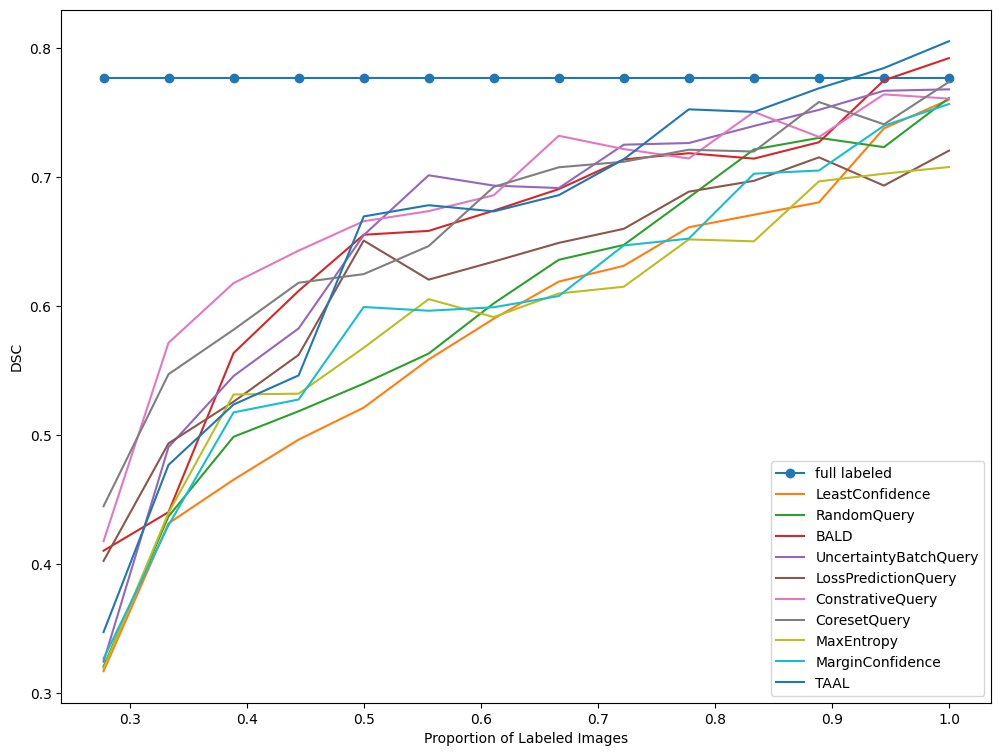

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(x, [0.7768]*14 , label="full labeled", marker="o")
for k,v in DSC.items():
    if k != "FullLabel":
        print(k)
        ax.plot(x, v, label=k)
ax.set_xlabel("Proportion of Labeled Images")
ax.set_ylabel("DSC")
ax.legend(fontsize=10)
plt.show()

In [11]:
IoU["FullLabel"][-1]

0.6394

LeastConfidence
RandomQuery
BALD
UncertaintyBatchQuery
LossPredictionQuery
ConstrativeQuery
CoresetQuery
MaxEntropy
MarginConfidence
TAAL


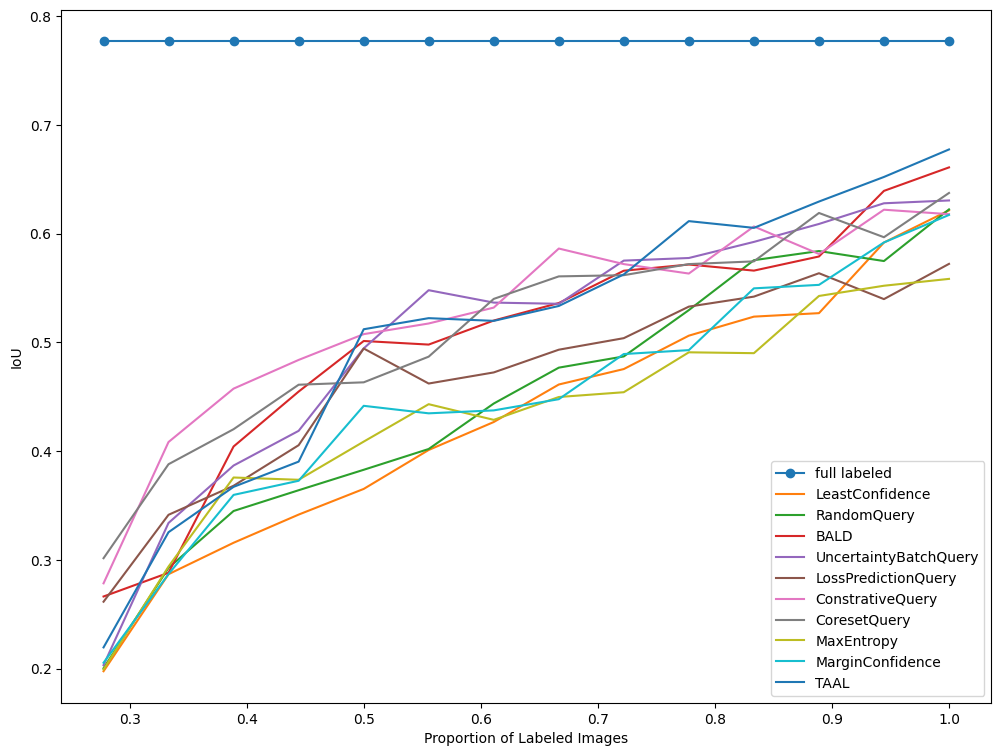

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(x, [0.7768]*14 , label="full labeled", marker="o")
for k,v in IoU.items():
    if k != "FullLabel":
        print(k)
        ax.plot(x, v, label=k)
ax.set_xlabel("Proportion of Labeled Images")
ax.set_ylabel("IoU")
ax.legend()
plt.show()

In [13]:
ASSD["FullLabel"][-1]

1.6783

LeastConfidence
RandomQuery
BALD
UncertaintyBatchQuery
LossPredictionQuery
ConstrativeQuery
CoresetQuery
MaxEntropy
MarginConfidence
TAAL


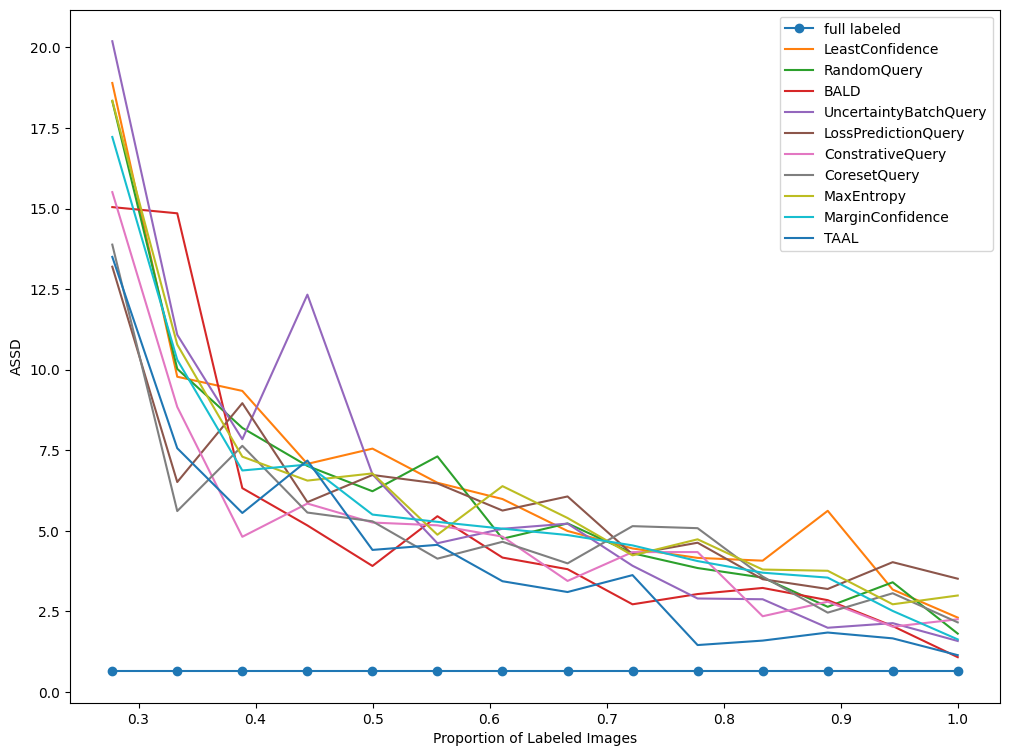

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(x, [ 0.6394]*14 , label="full labeled", marker="o")
for k,v in ASSD.items():
    if k != "FullLabel":
        print(k)
        ax.plot(x, v, label=k)
ax.set_xlabel("Proportion of Labeled Images")
ax.set_ylabel("ASSD")
ax.legend()
plt.show()